In [1]:
# Custom functionalities
import visionNew
from Utilities.metrics import pixelwiseAccuracy
from Utilities.datasetHandler import CityscapesDataset
from Utilities.modelHandler import modelFCN

import torch
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torch import nn
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.utils import draw_segmentation_masks

device = torch.device('cpu')
if torch.cuda.is_available(): device = torch.device('cuda')

torch.cuda.empty_cache()

In [2]:
### DATASET ###
img_directory = '/mnt/data/course/psarin/inm705/leftImg8bit'
ground_truth_directory = '/mnt/data/course/psarin/inm705/gtFine_trainvaltest/gtFine'
n_classes = 34

# Import datasets
dt_train = CityscapesDataset(image_directory = img_directory,
                            gt_directory = ground_truth_directory,
                            phase = 'train',
                            num_classes = n_classes)

dt_val = CityscapesDataset(image_directory = img_directory,
                            gt_directory = ground_truth_directory,
                            phase = 'val',
                            num_classes = n_classes)

dt_test = CityscapesDataset(image_directory = img_directory,
                            gt_directory = ground_truth_directory,
                            phase = 'test',
                            num_classes = n_classes)

# Initialise dataloaders
dataloader_args = {'batch_size':20, 'shuffle':False}

## TRAIN dataset
trainloader = DataLoader(dt_train, **dataloader_args)
## VAL dataset
valloader = DataLoader(dt_val, **dataloader_args)
## TEST dataset
testloader = DataLoader(dt_test, batch_size=10)


# Pascal VOC categories
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                      'cow', 'diningtable', 'dog', 'horse',
                      'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

# convert list to dict
pascal_voc_classes = {}
for id, name in enumerate(object_categories): 
    pascal_voc_classes[name]=id # these are the same indices used to create the label vector y in the dataset 
    

In [3]:
## MODEL Pretrained with RESNET 50
# Initialize model with the best available weights
FCN_weights = FCN_ResNet50_Weights.DEFAULT
backbone_weights = ResNet50_Weights.DEFAULT
model = fcn_resnet50(backbone_weights=backbone_weights).to(device)

model.backbone.requires_grad_(False)
model.classifier[4] = nn.Conv2d(512, n_classes, kernel_size=(1, 1), stride=(1, 1))
model.classifier.requires_grad_(True)

cel = CrossEntropyLoss()
ad = Adam(model.parameters())

fcn1 = modelFCN(model, loss_function=cel, optimizer = ad )
fcn1.model.to(device);

In [56]:
fcn1.model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [4]:
L = fcn1.train_model(trainloader, total_epochs=100, save_every_epochs = 10, ckp_name="test_22_02")

Completed epoch 1
Completed epoch 2
Completed epoch 3
Completed epoch 4
Completed epoch 5
Completed epoch 6
Completed epoch 7
Completed epoch 8
Completed epoch 9
Completed epoch 10
Completed epoch 11
Completed epoch 12
Completed epoch 13
Completed epoch 14
Completed epoch 15
Completed epoch 16
Completed epoch 17
Completed epoch 18
Completed epoch 19
Completed epoch 20
Completed epoch 21
Completed epoch 22
Completed epoch 23
Completed epoch 24
Completed epoch 25
Completed epoch 26
Completed epoch 27
Completed epoch 28
Completed epoch 29
Completed epoch 30
Completed epoch 31
Completed epoch 32
Completed epoch 33
Completed epoch 34
Completed epoch 35
Completed epoch 36
Completed epoch 37
Completed epoch 38
Completed epoch 39
Completed epoch 40
Completed epoch 41
Completed epoch 42
Completed epoch 43
Completed epoch 44
Completed epoch 45
Completed epoch 46
Completed epoch 47
Completed epoch 48
Completed epoch 49
Completed epoch 50
Completed epoch 51
Completed epoch 52
Completed epoch 53
Co

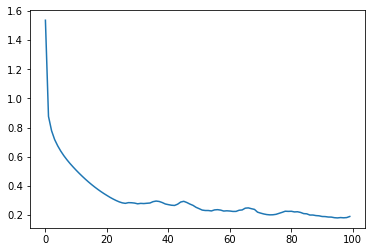

In [29]:
import matplotlib.pyplot as plt

plt.plot(L)

In [5]:
# Load checkpoint
fcn1.model.load_state_dict(torch.load("Checkpoints/test_epoch_3.pth"))
fcn1.model.eval();

In [5]:
# Step 4: Use the model and visualize the prediction
fcn1.model.eval()
_, X_test, y_test = next(iter(testloader))
X_test, y_test = X_test.to(device), y_test.to(device) 

fcn1.model.to(device)
pred = fcn1.model(X_test)['out']

# Apply sigmoid and threshold value
out = torch.sigmoid(pred) > 0.5
out = out.int()



0.047921713441610336

In [14]:
import numpy as np

def pixelwiseAccuracy(pred, gt):
    
    acc = []
    
    for idx, p in enumerate(pred): 
        #p = p.argmax(dim=0)
        yy = gt[idx]#.argmax(dim=0)   
    
        acc.append( ((p == yy)*1).sum() / (p.size(0)*p.size(1)*p.size(2)) )
            
    return (sum(acc) / len(acc)).item() # take the average across batch size
    

In [15]:
# Computing metrics
pixelwiseAccuracy(out,y_test)

0.9052811861038208

## Visualisation

In [52]:
X_viz, X_viz_norm = dt_test.get_image_visualization(6)

# Process the input inside with the model
pred_viz = fcn1.model(X_viz_norm.unsqueeze(0).to(device))['out']

out_viz = torch.sigmoid(pred_viz) > 0.5
out_viz = out_viz.int()[0] # unpack the batch with [0]

# Create the mask with argmax
mask = out_viz.argmax(dim=0)

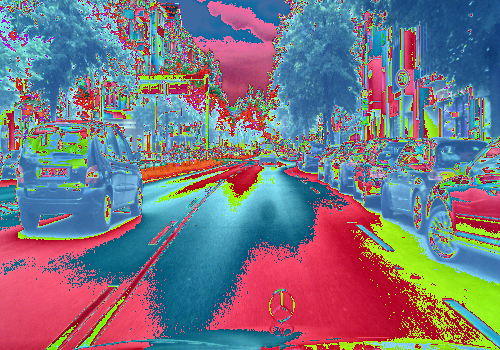

In [53]:
to_pil_image(X_viz_norm)

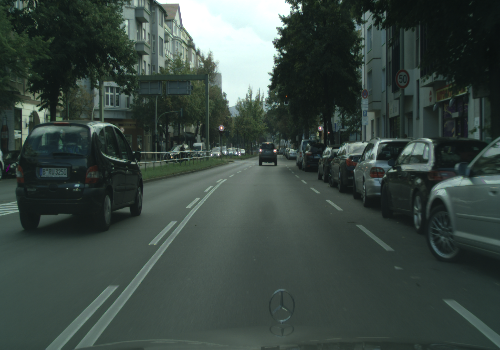

In [55]:
# Single class visualisation
class_id = 12
single_class_mask = (mask == class_id)

sm = draw_segmentation_masks(X_viz, masks=single_class_mask, alpha=0.7, colors = ( 81,  0, 81))
to_pil_image(sm)

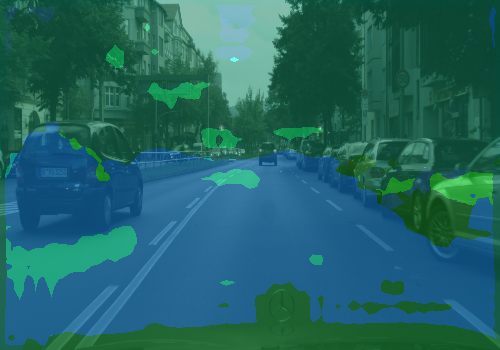

In [28]:
# Multiple class visualisation
bool_masks = mask.cpu() == torch.arange(n_classes)[:, None, None]

sm = draw_segmentation_masks(X_viz, masks=bool_masks, alpha=0.5)
to_pil_image(sm)

## Check the model

In [58]:
from Utilities.torchsummaryNew import summary

In [59]:
device = torch.device('cuda')

In [60]:
x = torch.randn(1, 3, 224, 224).to(device)
fcn1.model.to(device);

In [61]:
summary(fcn1.model, (3, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 128]           9,408
       BatchNorm2d-2          [-1, 64, 64, 128]             128
              ReLU-3          [-1, 64, 64, 128]               0
         MaxPool2d-4           [-1, 64, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]           4,096
       BatchNorm2d-6           [-1, 64, 32, 64]             128
              ReLU-7           [-1, 64, 32, 64]               0
            Conv2d-8           [-1, 64, 32, 64]          36,864
       BatchNorm2d-9           [-1, 64, 32, 64]             128
             ReLU-10           [-1, 64, 32, 64]               0
           Conv2d-11          [-1, 256, 32, 64]          16,384
      BatchNorm2d-12          [-1, 256, 32, 64]             512
           Conv2d-13          [-1, 256, 32, 64]          16,384
      BatchNorm2d-14          [-1, 256,

(tensor(32963682), tensor(9455650))

In [1]:
from visionNew.torchvision.models.segmentation import fcn_resnet50

#from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

ValueError: An entry is already registered under the name 'maxvit_t'.

## Labels

In [ ]:
from Utilities.cityscapesLables import CityscapesLabels

labels = CityscapesLabels.get_labels()

labels()

In [7]:
from collections import namedtuple

Label = namedtuple( 'Label' , [
            'name'        , 
            'id'          , # An integer ID that is associated with this label. The IDs are used to represent the label in ground truth images
            'trainId'     , 
            'ignoreInEval', # Whether pixels having this class as ground truth label are ignored during evaluations or not
            'color'       , # The color of this label
            ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
            #       name                     id    trainId   ignoreInEval   color
            Label(  'unlabeled'            ,  0 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'ego vehicle'          ,  1 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'rectification border' ,  2 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'out of roi'           ,  3 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'static'               ,  4 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'dynamic'              ,  5 ,      255 ,  True         , (111, 74,  0) ),
            Label(  'ground'               ,  6 ,      255 ,  True         , ( 81,  0, 81) ),
            Label(  'road'                 ,  7 ,        0 ,  False        , (128, 64,128) ),
            Label(  'sidewalk'             ,  8 ,        1 ,  False        , (244, 35,232) ),
            Label(  'parking'              ,  9 ,      255 ,  True         , (250,170,160) ),
            Label(  'rail track'           , 10 ,      255 ,  True         , (230,150,140) ),
            Label(  'building'             , 11 ,        2 ,  False        , ( 70, 70, 70) ),
            Label(  'wall'                 , 12 ,        3 ,  False        , (102,102,156) ),
            Label(  'fence'                , 13 ,        4 ,  False        , (190,153,153) ),
            Label(  'guard rail'           , 14 ,      255 ,  True         , (180,165,180) ),
            Label(  'bridge'               , 15 ,      255 ,  True         , (150,100,100) ),
            Label(  'tunnel'               , 16 ,      255 ,  True         , (150,120, 90) ),
            Label(  'pole'                 , 17 ,        5 ,  False        , (153,153,153) ),
            Label(  'polegroup'            , 18 ,      255 ,  True         , (153,153,153) ),
            Label(  'traffic light'        , 19 ,        6 ,  False        , (250,170, 30) ),
            Label(  'traffic sign'         , 20 ,        7 ,  False        , (220,220,  0) ),
            Label(  'vegetation'           , 21 ,        8 ,  False        , (107,142, 35) ),
            Label(  'terrain'              , 22 ,        9 ,  False        , (152,251,152) ),
            Label(  'sky'                  , 23 ,       10 ,  False        , ( 70,130,180) ),
            Label(  'person'               , 24 ,       11 ,  False        , (220, 20, 60) ),
            Label(  'rider'                , 25 ,       12 ,  False        , (255,  0,  0) ),
            Label(  'car'                  , 26 ,       13 ,  False        , (  0,  0,142) ),
            Label(  'truck'                , 27 ,       14 ,  False        , (  0,  0, 70) ),
            Label(  'bus'                  , 28 ,       15 ,  False        , (  0, 60,100) ),
            Label(  'caravan'              , 29 ,      255 ,  True         , (  0,  0, 90) ),
            Label(  'trailer'              , 30 ,      255 ,  True         , (  0,  0,110) ),
            Label(  'train'                , 31 ,       16 ,  False        , (  0, 80,100) ),
            Label(  'motorcycle'           , 32 ,       17 ,  False        , (  0,  0,230) ),
            Label(  'bicycle'              , 33 ,       18 ,  False        , (119, 11, 32) ),
            Label(  'license plate'        , -1 ,       -1 ,  True         , (  0,  0,142) ),
        ]

#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

In [17]:
name2label.get("car").color

(0, 0, 142)

In [30]:
## MODEL Pretrained with RESNET 50
# Initialize model with the best available weights
FCN_weights = FCN_ResNet50_Weights.DEFAULT
backbone_weights = ResNet50_Weights.DEFAULT
m = fcn_resnet50(weights=FCN_weights).to(device)

cel = CrossEntropyLoss()
ad = Adam(model.parameters())

f = modelFCN(m, loss_function=cel, optimizer = ad )
f.model.to(device);

In [33]:
X_viz, X_viz_norm = dt_test.get_image_visualization(6)

# Process the input inside with the model
pred_viz = f.model(X_viz_norm.unsqueeze(0).to(device))['out']

out_viz = torch.sigmoid(pred_viz) > 0.5
out_viz = out_viz.int()[0] # unpack the batch with [0]

# Create the mask with argmax
mask = out_viz.argmax(dim=0)

In [44]:
mask.size()

torch.Size([350, 500])

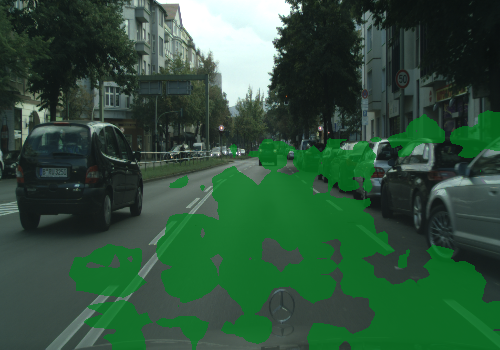

In [50]:
n_classes = 21
# Multiple class visualisation
bool_masks = out_viz.cpu() == torch.arange(n_classes)[:, None, None]

sm = draw_segmentation_masks(X_viz, masks=bool_masks, alpha=0.7)
to_pil_image(sm)

In [57]:
m

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti